# Homework 2 - Soccer analytics

### Libraries

In [1]:
import pandas as pd

import json
from pandas.io.json import json_normalize

# for the chi-squared test
from scipy.stats import chi2_contingency

# for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# for changing the dates of birth the correct way in RQ3
from datetime import date
import datetime

# [RQ1] Who wants to be a Champion?
#### Tasks:
1. Create a plot where each point (x,y) represents the number of points obtained by team x at game week y.
2. Highlight the two teams that got the longest winning streak and the two teams that got the longest losing streak.

### Datasets
In order to solve the question we need infos concerning only matches and teams. Let's take a look at the datasets.

In [2]:
matches = pd.read_json("matches_England.json")
teams = pd.read_json("teams.json")

In [3]:
matches.head(1)

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
0,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Burnley - AFC Bournemouth, 1 - 2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",Turf Moor,1659,2500089


In [4]:
teams.head(1)

,area,city,name,officialName,type,wyId
0,"{'name': 'England', 'id': '0', 'alpha3code': '...",Newcastle upon Tyne,Newcastle United,Newcastle United FC,club,1613


### Cleaning and setting the data
We drop the columns not needed of the datasets matches and teams.

The teams will be also filtered depending on their area, because we're going to use the list of English teams to build the final DataFrame to plot.

In [5]:
# from matches we need only the columns 'gameweek' (to sort the cumulative points later),
# 'teamsData' (to understand to which teams the game infos relate) and 'winner' (to assign the points later)
matches.drop(columns=['competitionId','date','duration','wyId','dateutc',
                      'label','referees','roundId','seasonId','status','venue'],
            inplace=True)

In [6]:
# from teams we need to build a dictionary of the teams playing in the English Championship only
# so that we'll be able to find the team name corresponding through its 'wyId'.
notEng = []
for i in range(len(teams)):
    if (teams.loc[i,'area']['alpha3code'] != 'XEN' and teams.loc[i,'area']['alpha3code'] != 'XWA') or teams.loc[i,'type'] != 'club':
        notEng += [i]
teams.drop(notEng,inplace=True)

teams.index=teams['wyId']
team = pd.Series.to_dict(teams['officialName'])

It is important to sort the rows of the DataFrame 'matches' in order to do the cumulative sum of the points in ascending order based on the weeks.

In [7]:
matches.sort_values('gameweek', inplace=True)

### Creating the table (English team)x(game week)
The entries we're going to put in the table are the points cumulated by each team in every game week.

In [8]:
num_weeks = matches['gameweek'].max()
gameweeks = list(range(1, num_weeks+1))
result = pd.DataFrame(index=teams['officialName'], columns=gameweeks)

In [9]:
length = len(matches)
for i in range(length):
    g_week = matches.loc[i,'gameweek']
    id1,id2 = list(map(int,matches.loc[i,'teamsData'].keys()))
    if not matches.loc[i,'winner']:
        result.loc[team[id1], g_week] = result.loc[team[id2], g_week] = 1
    elif matches.loc[i,'winner'] == id1:
        result.loc[team[id1], g_week] = 3
        result.loc[team[id2], g_week] = 0
    else:
        result.loc[team[id1], g_week] = 0
        result.loc[team[id2], g_week] = 3

In [10]:
result # at this point, we have the points gained per match per team, sorted by time

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
officialName,,,,,,,,,,,,,,,,,,,,,
Newcastle United FC,0,0,3,3,3,0,1,1,3,0,...,0,3,0,3,3,3,0,0,0,3
Huddersfield Town FC,3,3,1,0,1,1,0,0,3,0,...,0,1,0,0,1,3,1,0,1,0
Swansea City AFC,1,0,3,0,1,0,0,3,0,0,...,3,1,0,0,1,1,0,0,0,0
AFC Bournemouth,0,0,0,0,3,0,1,0,3,0,...,1,0,3,1,1,0,0,0,3,3
Brighton & Hove Albion FC,0,0,1,3,0,3,0,1,3,1,...,3,1,0,0,1,0,1,1,3,0
Burnley FC,3,0,1,3,1,1,3,1,0,3,...,3,3,0,3,3,3,1,1,0,0
Leicester City FC,0,3,0,0,1,0,1,1,3,3,...,1,3,3,3,0,0,1,0,0,0
West Ham United FC,0,0,0,3,1,0,3,1,0,1,...,0,0,1,3,1,1,0,0,3,3
Stoke City FC,0,3,1,1,0,0,3,0,0,3,...,1,0,0,0,0,1,1,1,0,3


### Task 1: points cumulated in each game week
The last thing to do is to cumulate the points gained by each team at every single week.

Then, in order to get the legend of the plot sorted as a ranking table of the Championship teams, we sort the columns of the DataFrame to plot so that the last row values (the final points) are in descending order.

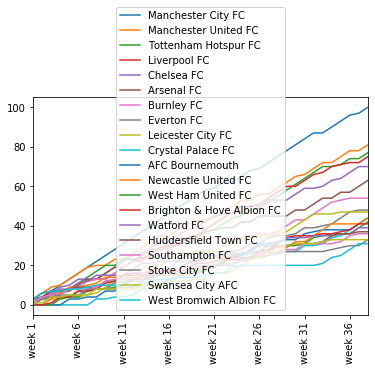

In [11]:
res = result.T.cumsum() # cumulating points for each game week

res = res.T.sort_values(num_weeks, ascending=False).T

# last thing: renaming the game week numbers (num) to strings ('week num')
res.index = list(map(lambda a: 'week '+str(a), res.index))

# let's plot!
res.plot()
plt.xticks(rotation=90)
plt.legend()

### Task 2: longest winning and losing streaks

The idea is to use a function which returns the longest streak of some value 'VAL' (representing a win or a loss) in a vector 'v' (the vector of points sorted by game week).

In this way, we get the table with the streaks for each team that has to be compared.

In [12]:
def streak(v, VAL):
    max = st = 0
    flag = 0
    # flag=1 means that we've already started to count the elements of a streak 'st'
    # flag=0 means that we're still searching for the first element of a streak 'st'
    
    for x in v:

        if x == VAL:
            
            if flag:
                st += 1
                
            else:
                flag = 1
                st += 1
            
        else:
            flag = 0
            if st > max:
                max = st
            st = 0
            
    return max

This function has to be applied to the DataFrame 'result', but first we have to transpose it.

In [13]:
result = result.T

In [14]:
wStreak = result.apply(lambda v: streak(v,3))
wStreak.sort_values(ascending=False, inplace=True)
wStreak

officialName
Manchester City FC           18
Tottenham Hotspur FC          7
Manchester United FC          4
Chelsea FC                    4
Liverpool FC                  4
Leicester City FC             4
Arsenal FC                    3
Burnley FC                    3
Newcastle United FC           3
Everton FC                    2
West Bromwich Albion FC       2
West Ham United FC            2
Crystal Palace FC             2
Brighton & Hove Albion FC     2
AFC Bournemouth               2
Swansea City AFC              2
Huddersfield Town FC          2
Watford FC                    2
Stoke City FC                 1
Southampton FC                1
dtype: int64

In [15]:
lStreak = result.apply(lambda v: streak(v,0))
lStreak.sort_values(ascending=False, inplace=True)
lStreak

officialName
West Bromwich Albion FC      8
Crystal Palace FC            7
Huddersfield Town FC         5
Watford FC                   4
Swansea City AFC             4
AFC Bournemouth              4
Stoke City FC                4
Newcastle United FC          4
Everton FC                   3
West Ham United FC           3
Burnley FC                   3
Brighton & Hove Albion FC    3
Southampton FC               3
Arsenal FC                   3
Leicester City FC            2
Chelsea FC                   2
Manchester City FC           1
Manchester United FC         1
Tottenham Hotspur FC         1
Liverpool FC                 1
dtype: int64

#### List of the two teams with the longest winning streak (sorted)

In [16]:
list(wStreak.index[0:2])

['Manchester City FC', 'Tottenham Hotspur FC']

#### List of the two teams with the longest losing streak (sorted)

In [17]:
list(lStreak.index[0:2])

['West Bromwich Albion FC', 'Crystal Palace FC']

# [RQ2] Is there a home-field advantage?
It is generally believed that there is an underlying home field advantage in sport, i.e. an highest probability of winning of the home team. Let's check for this, and see whether the outcome of the game (win, draw, lose) is correlated to the playing side (home or away). For 5 different teams of Premier League, show the contingency table (outcome x side). Therefore, perform an "overall" Chi-squared test in the following way: build a unique contingency table, that contains all the matches in which only one of the 5 teams previously selected is involved, to see whether there is home field advantage. State clearly the tested hypothesis and whether it is accepted or rejected.

In [18]:
matches_England = pd.read_json('matches_England.json', orient='columns') #read Premier League
#matches_England has many variables and there is a variable that the name is teamData that is a unique table in
#to the matches_England and we need it for this question. So we seprate it from matches_England.

user_dict = matches_England['teamsData'].to_dict()
data = pd.DataFrame.from_dict({(i,j):user_dict[i][j]
                           for i in user_dict.keys() 
                           for j in user_dict[i].keys()},
                    orient='index')

#the formation variables is not important for us so we delete it from our data.
del data['formation']
data.head(5)

scoreET  coachId  side  teamId  score  scoreP  hasFormation  scoreHT
0 1646        0     8880  home    1646      1       0             1        1
  1659        0     8934  away    1659      2       0             1        0
1 1627        0        0  away    1627      0       0             1        0
  1628        0     8357  home    1628      2       0             1        0
2 1609        0     7845  away    1609      1       0             1        1

In [19]:
#for calculating the final score we need the score (Score at the end of the match (not counting penalties) and
#the score at the penalty and the score in Extra time. so we sum them together.
data['final score']=data['score']+data['scoreP']+data['scoreET']

data.head()

scoreET  coachId  side  teamId  score  scoreP  hasFormation  scoreHT  \
0 1646        0     8880  home    1646      1       0             1        1   
  1659        0     8934  away    1659      2       0             1        0   
1 1627        0        0  away    1627      0       0             1        0   
  1628        0     8357  home    1628      2       0             1        0   
2 1609        0     7845  away    1609      1       0             1        1   

        final score  
0 1646            1  
  1659            2  
1 1627            0  
  1628            2  
2 1609            1

In [20]:
#now our data is ready for finding the winner and loser of the matches but first of all we need to rearrange the
#index of our table.
data.index=range(len(data['scoreET']))

data.head()

,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT,final score
0,0,8880,home,1646,1,0,1,1,1
1,0,8934,away,1659,2,0,1,0,2
2,0,0,away,1627,0,0,1,0,0
3,0,8357,home,1628,2,0,1,0,2
4,0,7845,away,1609,1,0,1,1,1


In [21]:
#So with the following code we compare each pair of teams and define who is winner and who is loser. and if
#match was draw, we showed it too and put them in to new columns which is called result.
for i in range (0,(len(data)-1),2):
    if ((data.iloc[i]['final score'] > data.iloc[i+1]['final score'])==True):
        data.loc[i,'result']='win'
        data.loc[i+1,'result']='lose'
    elif ((data.iloc[i]['final score'] < data.iloc[i+1]['final score'])==True):
        data.loc[i,'result']='lose'
        data.loc[i+1,'result']='win'
    else:
        data.loc[i,'result']='draw'
        data.loc[i+1,'result']='draw'
        
data.head()

,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT,final score,result
0,0,8880,home,1646,1,0,1,1,1,lose
1,0,8934,away,1659,2,0,1,0,2,win
2,0,0,away,1627,0,0,1,0,0,lose
3,0,8357,home,1628,2,0,1,0,2,win
4,0,7845,away,1609,1,0,1,1,1,win


In [22]:
#we choose 5 team and write their teamId into a list. and built a subdata1 which is involved some information
#about the specific teams.
list1=[1646,1627,1673,1633,1611]
subdata1=(data.loc[data['teamId'].isin(list1)])
          
subdata1.head(5)

,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT,final score,result
0,0,8880,home,1646,1,0,1,1,1,lose
2,0,0,away,1627,0,0,1,0,0,lose
5,0,18572,home,1673,0,0,1,0,0,lose
8,0,3295,home,1611,1,0,1,1,1,win
19,0,8235,home,1633,3,0,1,1,3,win


In [23]:
#with these code we built a dictionary which has data about the number of wins, losses and draws in home or away
#for those specific teams.
d = {}
for p in list1:
    d[p]={'home':[(len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'home') & (subdata1.result == 'win')])),
          (len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'home') & (subdata1.result == 'lose')])),
          (len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'home') & (subdata1.result == 'draw')]))],
          'away':[(len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'away') & (subdata1.result == 'win')])),
          (len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'away') & (subdata1.result == 'lose')])),
          (len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'away') & (subdata1.result == 'draw')]))]}
d

{1646: {'home': [7, 7, 5], 'away': [7, 5, 7]},
 1627: {'home': [3, 7, 9], 'away': [3, 12, 4]},
 1673: {'home': [6, 8, 5], 'away': [3, 11, 5]},
 1633: {'home': [7, 6, 6], 'away': [3, 10, 6]},
 1611: {'home': [15, 2, 2], 'away': [10, 5, 4]}}

In [24]:
#built 5 dataframe for each team. in another word, we sperate each team of d dictionary into a dataframe
df1646=pd.DataFrame(data=d[1646],index=['wins','losses','draws'])
df1627=pd.DataFrame(data=d[1627],index=['wins','losses','draws'])
df1673=pd.DataFrame(data=d[1673],index=['wins','losses','draws'])
df1633=pd.DataFrame(data=d[1633],index=['wins','losses','draws'])
df1611=pd.DataFrame(data=d[1611],index=['wins','losses','draws'])

print (df1646.T)
print (df1627.T)
print (df1673.T)
print (df1633.T)
print (df1611.T)

      wins  losses  draws
home     7       7      5
away     7       5      7
      wins  losses  draws
home     3       7      9
away     3      12      4
      wins  losses  draws
home     6       8      5
away     3      11      5
      wins  losses  draws
home     7       6      6
away     3      10      6
      wins  losses  draws
home    15       2      2
away    10       5      4


In [25]:
#with following code we could find chi-squared and p-value
re=chi2_contingency(df1611)
print('the chi-squared is',re[0],'and the p-value is',re[1])

the chi-squared is 2.9523809523809526 and the p-value is 0.22850653346991975


# [RQ3] Which teams have the youngest coaches?
Rank all the teams by the age of their coach and show the 10 teams with the youngest coaches. Remember that during a season a team could have more coaches, in that case pick the younger of them. Additionally, show the distirbutions of the ages of all coaches in Premier League, using a boxplot. (Hint: There's an attribute birthDate).

### Datasets

In [26]:
coaches = pd.read_json('coaches.json', orient='columns')
teams = pd.read_json('teams.json', orient='columns')


### Cleaning the data

In [27]:
# correcting the date column
coaches['birthDate'] = pd.to_datetime(coaches['birthDate'])

# selecting the columns needed
columns=['shortName','currentTeamId','birthDate']
coachesData = pd.DataFrame(data=coaches,columns=columns)
coachesData.head(5)

,shortName,currentTeamId,birthDate
0,Cesar Domingo,0,NaT
1,J. Heynckes,0,1945-05-09
2,G. De Biasi,0,1956-06-16
3,Marcelino,674,1965-08-14
4,T. Korkut,0,1974-04-02


### Sorting

In [28]:
coachesData.sort_values(by=['birthDate'], ascending=False, inplace=True)
coachesData.tail()

,shortName,currentTeamId,birthDate
92,R. Hodgson,1628,1947-08-09
145,Ó. Tabárez,0,1947-03-03
1,J. Heynckes,0,1945-05-09
0,Cesar Domingo,0,NaT
75,F. Da Cruz,0,NaT


We notice that not all the coaches have a legit 'birthDate' in the dataset. We complete the information in that column for Mendiondo Lopez and Da Cruz (with google's help), which are the only ones that miss it.

PS: that's not necessary because these two coaches are not in English teams

In [29]:
coachesData.loc[0,'birthDate'] = pd.Timestamp(1966, 6, 25)
coachesData.loc[75,'birthDate'] = pd.Timestamp(1966, 6, 25)

### Calculating age for fun

In [30]:
def calculateAge(birthDate): 
    today = date.today() 
    age = today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day))
    return age

# calculating the age from birthDate to put in a new column (Age) on the coachesData dataframe
for i in range (len(coachesData)):
    coachesData.loc[i,'Age']=calculateAge(coachesData.loc[i,'birthDate'])
coachesData.head()

,shortName,currentTeamId,birthDate,Age
117,J. Nagelsmann,2482,1987-07-23,32.0
146,D. Tedesco,0,1985-09-12,34.0
61,F. Kohfeldt,2443,1982-10-05,37.0
157,H. Wolf,2450,1981-04-15,38.0
184,L. Zubeldía,0,1981-01-13,38.0


### Selecting only English teams' coaches

In [31]:
teams['country'] = list(map(lambda i: i['name'], teams.area))

In [32]:
# preparing the data in 'teams' dataset to access them through the team wyId
teams.index = teams.wyId

def country_from_id(id, label):
    try:
        return teams.loc[id, label]
    except KeyError:
        return 'not found'

coachesData['country'] = list(map(lambda id: country_from_id(id, 'country'), coachesData['currentTeamId']))
    
# showing readable team names for the coaches, using the info in teams
coachesData['currentTeamName'] = list(map(lambda id: country_from_id(id, 'officialName'), coachesData['currentTeamId']))

# selecting English teams' coaches
coachesData = coachesData[coachesData.country=='England']
coachesData.head(10)

,shortName,currentTeamId,birthDate,Age,country,currentTeamName
56,E. Howe,1659,1977-11-29,41.0,England,AFC Bournemouth
170,Marco Silva,1623,1977-07-12,42.0,England,Everton FC
73,Paco,1613,1973-02-19,46.0,England,Newcastle United FC
90,M. Pochettino,1624,1972-03-02,47.0,England,Tottenham Hotspur FC
50,Unai Emery,1609,1971-11-03,47.0,England,Arsenal FC
87,S. Dyche,1646,1971-06-28,48.0,England,Burnley FC
164,Guardiola,1625,1971-01-18,48.0,England,Manchester City FC
155,Javi Gracia,1644,1970-05-01,49.0,England,Watford FC
37,R. Hasenhüttl,1619,1967-08-09,52.0,England,Southampton FC
47,J. Klopp,1612,1967-06-16,52.0,England,Liverpool FC


### Discarding the oldest coaches for each team
This is done by keeping for every team only the first line in which it appears: that automatically select its youngest coach.

Maybe this doesn't work as expected because the data do not keep memory of past coaches, in fact only a 'current' team is indicated.

In [84]:
def first_row(df):
    return pd.Series.to_frame(df.iloc[0]).T

result = coachesData.groupby('currentTeamName').apply(first_row)
result = result[['birthDate', 'Age', 'shortName', 'currentTeamName']]
result.reset_index(drop=True, inplace=True)
result.sort_values(by=['birthDate'], ascending=False, inplace=True)

In [85]:
# Answer
result.head(10)

,birthDate,Age,shortName,currentTeamName
0,1977-11-29 00:00:00,41,E. Howe,AFC Bournemouth
6,1977-07-12 00:00:00,42,Marco Silva,Everton FC
9,1973-02-19 00:00:00,46,Paco,Newcastle United FC
11,1972-03-02 00:00:00,47,M. Pochettino,Tottenham Hotspur FC
1,1971-11-03 00:00:00,47,Unai Emery,Arsenal FC
3,1971-06-28 00:00:00,48,S. Dyche,Burnley FC
8,1971-01-18 00:00:00,48,Guardiola,Manchester City FC
12,1970-05-01 00:00:00,49,Javi Gracia,Watford FC
10,1967-08-09 00:00:00,52,R. Hasenhüttl,Southampton FC
7,1967-06-16 00:00:00,52,J. Klopp,Liverpool FC


# [RQ4] Who are the top 10 players with the highest ratio between completed passes and attempted passes?

### Datasets

In [35]:
players = pd.read_json('players.json')
teams = pd.read_json('teams.json')
events = pd.read_json('events_England.json')

### Cleaning the data

In [36]:
# we need only passes for this task, so we filter the events as follows
passes = events[events['eventName']=='Pass']

# we select only the relevant columns:
# 'playerId' is necessary to attribute a single pass to the player who did it
# 'tags' are necessary to distinguish completed passes
passes = passes[['playerId','tags']]

# from 'players' dataset we create a dictionary of players with wyIds as keys
# this is useful to translate a player id into his name, so that the result will be human-friendly
players.index = players['wyId']
players['Name'] = players['firstName'] + ' ' + players['lastName']
players = players[['Name']]
pl_dict = pd.Series.to_dict(players['Name'])

In the column 'tags' there are a few dictionaries and only one of them can store the tag '1801' which tells us that the pass was completed. In order to make the data clearer, we define a function which can change an entry of this column to 1 if '1801' is found and 0 otherwise. Then, we apply it to the column's cells.

In [37]:
def myFind(L, x):
    for i in L:
        if i['id'] == x:
            return 1
    return 0

passes['tags'] = list(map(lambda a: myFind(a, 1801), list(passes['tags'])))

# now the column 'tags' indicates whether the pass was completed or not, so we change its name for clarity
passes.columns=['playerId','completed passes']

### Counting total and completed passes

In order to count the total number of passes attempted by each player, it is sufficient to calculate the number of rows in which each player compares:

In [38]:
passes_per_player = passes.groupby('playerId').apply(len)
passes_per_player.head()

playerId
0        6
36     898
38     224
48    2370
54    2196
dtype: int64

Instead, in order to count how many passes each player has completed, we can count how many 1s are in the column 'completed passes' for each player:

In [39]:
result = passes.groupby('playerId').sum()
result['passes'] = passes_per_player
result.head()

,completed passes,passes
playerId,,
0,0,6
36,790,898
38,192,224
48,2113,2370
54,1803,2196


### Calculating the ratio (completed passes)/(total passes)

In [40]:
def div_lists(a, b):
    res = []
    l = len(a)
    for i in range(l):
        res += [ a[i]/b[i] ]
    return res

result['ratio'] = div_lists(list(result['completed passes']), list(result['passes']))

# sort the players in ascending ordered based on the ratio
result.sort_values(['ratio'],ascending=False,inplace=True)
result.head(10)

,completed passes,passes,ratio
playerId,,,
532949,1,1,1.0
447538,1,1,1.0
447254,4,4,1.0
423162,18,18,1.0
415747,6,6,1.0
353241,4,4,1.0
340476,1,1,1.0
291528,7,7,1.0
227756,4,4,1.0


### Setting the threshold of minimum passes
This is important not to give insignificant statistics.

An easy way to set it is to take the average number of total passes per player.

In [41]:
minimum = passes_per_player.mean()
minimum

639.4105058365759

In [42]:
# filter the data with the threshold chosen
result = result[result['passes'] > minimum]

### Assigning names corresponding to the playerIds

In [43]:
result['playerName'] = list(map(lambda id: pl_dict[id], list(result.index)))

result.reset_index(drop=True, inplace=True)

# show the names of the first ten players with the best ratio (filtering with respect to the threshold)
result[['playerName']].head(10)

,playerName
0,John Stones
1,Fabian Delph
2,Vincent Kompany
3,Andreas Christensen
4,Phil Jones
5,Nicol\u00e1s Hern\u00e1n Otamendi
6,Mohamed Naser Elsayed Elneny
7,\u0130lkay G\u00fcndo\u011fan
8,Victor Nilsson Lindel\u00f6f
9,Moussa Sidi Yaya Demb\u00e9l\u00e9


# [RQ5] Does being a tall player mean winning more air duels?
Make a plot (scatterplot) that shows the dependency between height of the player and the ratio of air duels won with air duels attempted.

*Constraint*: any point should be coloured according to an arbitrary selection of categories of height (e.g. yellow: 160-165cm, orange: 165-170cm, etc.)

### Datasets

In [44]:
events = pd.read_json('events_England.json')
players = pd.read_json('players.json')
events.head(1)

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,[{'id': 1801}],1609


In [45]:
players.head(1)

,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",1989-06-17,4687,4502,Harun,right,187,Tekin,,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...","{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...",H. Tekin,78,32777


### Cleaning and setting the data

In [46]:
# creating the dictionary "pl_heights" for players' heights to access through players' wyIds
players.set_index(['wyId'], inplace=True)
pl_heights = players[['height']]
pl_heights = pd.Series.to_dict(players['height'])

# selecting air duels from the events and keeping info to find out the winner
airduels = events[events['subEventName']=='Air duel']
airduels = airduels[['playerId','tags']]

### Finding won air duels

In [47]:
def myFind(L, x):
    for i in L:
        if i['id'] == x:
            return 1
    return 0

airduels['won'] = list(map(lambda a: myFind(a, 1801), list(airduels['tags'])))
airduels.drop(columns=['tags'], inplace=True)
airduels.head()

,playerId,won
7,8013,0
8,0,1
12,8653,1
13,25413,0
27,192748,1


Notice that some of the air duels are related to players whose id is not specified (0 doesn't correspond to any player in the players dataset), so we filter those events because we can't find the height of the player.

In [48]:
airduels = airduels[airduels['playerId']!=0]
airduels.head()

,playerId,won
7,8013,0
12,8653,1
13,25413,0
27,192748,1
28,7945,0


### Calculating total, won air duels, and ratios

In [49]:
airduels['heights'] = list(map(lambda a: pl_heights[a], list(airduels['playerId'])))
airduels = airduels[['heights','won']]
airduels.head()

,heights,won
7,175,0
12,188,1
13,175,0
27,181,1
28,185,0


In [50]:
df = airduels.groupby(['heights']).sum()
df['tot'] = airduels.groupby(['heights']).apply(len)

# 'ratio' column is given by dividing each element of 'won' column by each of 'tot' column
def div_lists(a, b):
    res = []
    l = len(a)
    for i in range(l):
        res += [ a[i]/b[i] ]
    return res
df['ratio'] = div_lists(list(df['won']), list(df['tot']))

df.reset_index(inplace=True)
df

,heights,won,tot,ratio
0,163,16,41,0.390244
1,165,13,35,0.371429
2,167,17,92,0.184783
3,168,71,163,0.435583
4,169,31,106,0.292453
5,170,124,256,0.484375
6,171,47,153,0.307190
7,172,107,266,0.402256
8,173,271,624,0.434295
9,174,278,578,0.480969


### Threshold and filtered ranking table

In [51]:
minimum = df['tot'].sum() / len(df)
minimum

966.3333333333334

In [52]:
tot_cat = 5

a = df['heights'].min()
b = df['heights'].max()
skip = (b-a)/tot_cat

categories = []
for i in range(tot_cat):
    categories += [[a+i*skip, a+(i+1)*skip]]
    
def choose_cat(num):
    for i in range(tot_cat):
        if num >= categories[i][0] and num < categories[i][1]:
            return a+i*skip
    # in case the function has not returned anything, it means we're on the last value of the interval [a,b]
    return b-skip

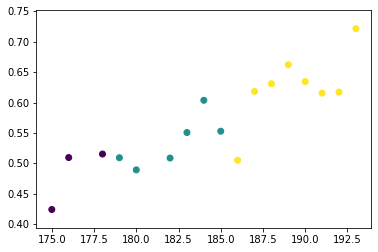

In [53]:
df.reset_index()


df = df[df['tot'] > minimum]



plt.scatter(x = df['heights'],
           y = df['ratio'],
           c = list(map(choose_cat, df['heights'])))

# [RQ6] Other results

## Linear regression applied to RQ5

In [54]:
import statsmodels.api as sm

X=df['heights']
y=df['ratio']

model = sm.OLS(y, X).fit()

model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ratio   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              1450.
Date:                Thu, 31 Oct 2019   Prob (F-statistic):                    3.98e-17
Time:                        02:12:56   Log-Likelihood:                          23.725
No. Observations:                  17   AIC:                                     -45.45
Df Residuals:                      16   BIC:                                     -44.62
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
heights        0.0031   8.11e-05     38.075      0.000       0.003       0.003
==============================================================================
Omnibus:                        0.106   Durbin-Watson:                   0.682
Prob(Omnibus):                  0.949   Jarque-Bera (JB):                0.263
Skew:                           0.151   Prob(JB):                        0.877
Kurtosis:                       2.471   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared is very close to 1, that means that the RSS (Residual Sum of Squares) is close to 0, so the dependence of the data of won air duels with respect to the height is almost linear.

# [CRQ1] What are the time slots of the match with more goals?
1. Make a barplot with the absolute frequency of goals in all the time slots.
2. Find the top 10 teams that score the most in the interval "81-90".
3. Show if there are players that were able to score at least one goal in 8 different intervals.

### Datasets

In [55]:
ENG = pd.read_json("events_England.json")
FRA = pd.read_json("events_France.json")
GER = pd.read_json("events_Germany.json")
ITA = pd.read_json("events_Italy.json")
SPA = pd.read_json("events_Spain.json")
teams = pd.read_json("teams.json")
players = pd.read_json("players.json")

In [56]:
events = pd.concat([ENG,FRA,GER,ITA,SPA], axis=0)

### Cleaning the data
First, we select only goals by using the tag '101'.

In [57]:
events['tags'] = list(map(lambda a: myFind(a, 101), list(events['tags'])))
# now the column 'tags' indicates whether the event corresponds to a goal or not
# Note: myFind has been defined for previous questions

goals = events[events.tags==1]
goals.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
46,10,Shot,94.595788,177959212,2499719,1H,25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",100,Shot,1,1609
47,9,Save attempt,96.970614,177959226,2499719,1H,8480,"[{'y': 100, 'x': 100}, {'y': 59, 'x': 12}]",90,Reflexes,1,1631
91,10,Shot,254.745027,177959280,2499719,1H,14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",100,Shot,1,1631
92,9,Save attempt,256.547834,177959249,2499719,1H,7882,"[{'y': 0, 'x': 0}, {'y': 48, 'x': 4}]",90,Reflexes,1,1609
554,10,Shot,1710.855093,177959759,2499719,1H,12829,"[{'y': 54, 'x': 94}, {'y': 100, 'x': 100}]",100,Shot,1,1631


And we keep only useful columns, so 'eventSec' and 'matchPeriod'.

In [58]:
goals = goals[['playerId','teamId','eventSec','matchPeriod']]
goals.head()

,playerId,teamId,eventSec,matchPeriod
46,25413,1609,94.595788,1H
47,8480,1631,96.970614,1H
91,14763,1631,254.745027,1H
92,7882,1609,256.547834,1H
554,12829,1631,1710.855093,1H


### Slot assignment
In order to do this assignment, we define a function to be applied to the second corresponding to each goal.

We divide the time in slots of 9 min and order them from 0 to 11, considering that there are extra times.

The plot will be done so that slots are in ascending order with respect to time.

In [59]:
# This function will return the number of the slot inside the period, so it goes from 0 to 5.
# Then we'll adjust it from 0 to 11 using the information stored in the column 'matchPeriod'.
def sec_to_slot(second):
    min = second/60
    slot = 6
    for i in range(5):
        a = i*9
        if min >= a and min < a+9:
            slot = i+1
    return slot

In [60]:
goals['timeSlot'] = list(map(sec_to_slot, goals['eventSec']))
goals['timeSlot'] = goals['timeSlot'] + 6*(goals['matchPeriod'] == '2H')
goals.head()

,playerId,teamId,eventSec,matchPeriod,timeSlot
46,25413,1609,94.595788,1H,1
47,8480,1631,96.970614,1H,1
91,14763,1631,254.745027,1H,1
92,7882,1609,256.547834,1H,1
554,12829,1631,1710.855093,1H,4


### Task 1: Plotting the number of goals per time-slot

In [61]:
goals_per_slot = pd.Series.to_frame(goals.groupby('timeSlot').apply(len))

<BarContainer object of 12 artists>

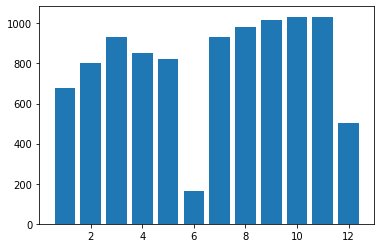

In [62]:
plt.bar(goals_per_slot.index, goals_per_slot[0])

### Task 2: top 10 teams that score the most in the slot [81-90)

In [63]:
slot10 = goals[goals.timeSlot==10]
slot10 = pd.Series.to_frame(slot10.groupby('teamId').apply(len))
slot10.sort_values(by=0, ascending=False, inplace=True)

In [64]:
# Making teams' official names accessible through their wyIds (to be set as indexes)
teams.index = teams.wyId

slot10.index = list(map(lambda id: teams.loc[id,'officialName'], slot10.index))
slot10.columns = ['total goals between minute 81 and 90']
slot10.head(10)

,total goals between minute 81 and 90
Paris Saint-Germain FC,21
Real Betis Balompi\u00e9,17
Everton FC,17
Olympique de Marseille,17
West Ham United FC,16
Stoke City FC,15
Deportivo Alav\u00e9s,15
Eintracht Frankfurt,15
Real Club Celta de Vigo,14
Benevento Calcio,14


### Task 3: players who scored at least one goal in 8 different intervals

In [65]:
# cleaning the data
goals_pl = goals[['playerId','timeSlot']]

# keep only one line per different time-slot for each player
goals_pl = goals_pl.groupby(['playerId','timeSlot']).count()

# counting the number of different time-slots per player
result = pd.Series.to_frame(goals_pl.groupby(['playerId']).apply(len))
result.columns=['different time slots']

result.head()

,different time slots
playerId,
0,2
33,1
54,7
74,1
77,2


In [66]:
# filtering players with not enough different time-slots
result = result[result['different time slots']>7]
result.sort_values(by='different time slots', ascending=False, inplace=True)

# making teams' official names accessible through their wyIds (to be set as indexes)
players.index = players.wyId

# changin indexes from players' wyIds to players' names
result.index = list(map(lambda id: players.loc[id,'shortName'], result.index))

result

,different time slots
B. Lecomte,12
V. Belec,12
K. Casteels,12
R. Zentner,12
R. B\u00fcrki,12
K. Johnsson,12
Nicolas,12
Rub\u00e9n Blanco,12
B. Foster,12
Ederson,12


As we can see, there are lots of players who scored in 8 or more different time slots.

# [CRQ2] Visualize movements and passes on the pitch!
Task 1. Considering only the match Barcelona - Real Madrid played on the 6 May 2018:

* visualize with a heatmap the zones where Cristiano Ronaldo was more active. The events to be considered are: passes, shoots, duels, free kicks.

* compare his map with the one of Lionel Messi. Comment the results and point out the main differences (we are not looking for deep and technique analysis, just show us if there are some clear differences between the 2 plots).

Task 2. Considering only the match Juventus - Napoli played on the 22 April 2018:

* visualize with arrows the starting point and ending point of each pass done during the match by Jorginho and Miralem Pjanic. Is there a huge difference between the map with all the passes done and the one with only accurate passes? Comment the results and point out the main differences.

### Datasets

In [67]:
matchesSPA = pd.read_json('matches_Spain.json')
matchesITA = pd.read_json('matches_Italy.json')
eventsSPA = pd.read_json('events_Spain.json')
eventsITA = pd.read_json('events_Italy.json')
players = pd.read_json('players.json')

## Task 1
### Cleaning the data

In [68]:
# selection of the match required
match1 = matchesSPA[matchesSPA.label.str.contains('Barcelona - Real Madrid', regex=False)== True]

# extracting Ronaldo and Messi's wyIds
id_Ronaldo = (players[players.shortName.str.contains('Ronaldo', regex=False)]).iloc[0]['wyId']
id_Messi = (players[players.shortName.str.contains('Messi', regex=False)]).iloc[0]['wyId']

In [69]:
# selecting the events related to the match Barcelona - Real Madrid
events1 = eventsSPA[eventsSPA['matchId'] == match1.iloc[0]['wyId']]
# selecting only the events needed (passes, shoots, duels, free kicks)
events1 = events1[events1['eventName'].isin(['Pass', 'Shot', 'Duel', 'Free Kick'])]

# selecting Ronaldo's and Messi's actions respectively
ev_Ronaldo = events1[events1.playerId == id_Ronaldo]
ev_Messi = events1[events1.playerId == id_Messi]

# selecting only necessary info about actions (positions)
ev_Ronaldo = ev_Ronaldo[['positions']]
ev_Messi = ev_Messi[['positions']]

### Drawing the heatmaps

In [70]:
def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = matplotlib.patches.Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = matplotlib.patches.Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = matplotlib.patches.Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = matplotlib.patches.ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = matplotlib.patches.Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = matplotlib.patches.Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = matplotlib.patches.Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = matplotlib.patches.Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

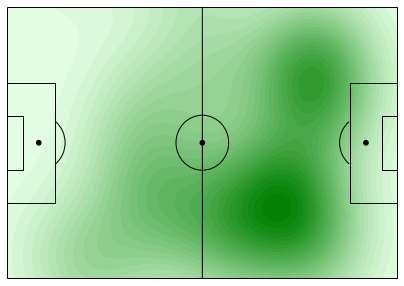

In [71]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-0.1, 80)
plt.xlim(0, 120.1)
plt.axis('off')

fig.set_size_inches(7, 5)

xRonaldo = [i[0]['x'] for i in ev_Ronaldo['positions']]
yRonaldo = [i[0]['y'] for i in ev_Ronaldo['positions']]

sns.kdeplot(xRonaldo, yRonaldo, shade=True, color='green', n_levels=30)

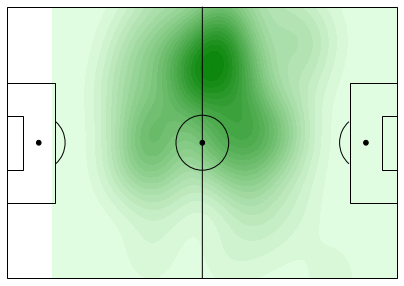

In [72]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-.1, 80)
plt.xlim(0, 120.1)
plt.axis('off')

xMessi = [i[0]['x'] for i in ev_Messi['positions']]
yMessi = [i[0]['y'] for i in ev_Messi['positions']]

sns.kdeplot(xMessi, yMessi, shade=True, color='green', n_levels=30)

Ronaldo played a lot more in the fore half of the field and on both sides, while Messi stayed mostly near the center of the field, but almost always on the right side.

## Task 2
### Cleaning the data

In [73]:
# selection of the match required
match2 = matchesITA[matchesITA.label.str.contains('Juventus - Napoli', regex=False)== True]

# extracting Ronaldo and Messi's wyIds
id_Jorginho = (players[players.shortName.str.contains('Jorginho', regex=False)]).iloc[0]['wyId']
id_Pjanic = (players[players.firstName.str.contains('Miralem', regex=False)]).iloc[0]['wyId']

In [74]:
# selecting the events related to the match required
events2 = eventsITA[eventsITA['matchId'] == match2.iloc[0]['wyId']]
# selecting only the events needed (passes, shoots, duels, free kicks)
events2 = events2[events2['eventName']=='Pass']

# selecting those involving Jorginho and Pjanic separately
passes_Jorg = events2[events2['playerId']==id_Jorginho][['positions','tags']]
passes_Pjan = events2[events2['playerId']==id_Pjanic][['positions','tags']]

### Drawing arrows per each Pass of Jorginho and Pjanic (even not accurate)

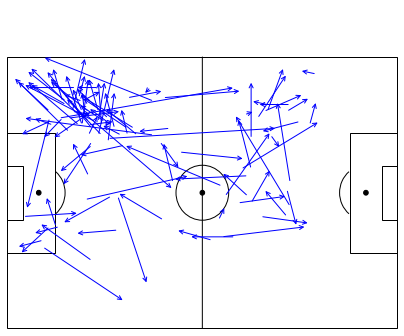

In [75]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-.1, 80)
plt.xlim(0, 120.1)
plt.axis('off')

for i in range(len(passes_Jorg)):
    # annotate draws an arrow from a current position to pass_end_location
    ax.annotate("",
                xy = (passes_Jorg.iloc[i]['positions'][1]['y'],
                          passes_Jorg.iloc[i]['positions'][1]['x']),
                xycoords = 'data',
                xytext = (passes_Jorg.iloc[i]['positions'][0]['y'],
                          passes_Jorg.iloc[i]['positions'][0]['x']),
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)

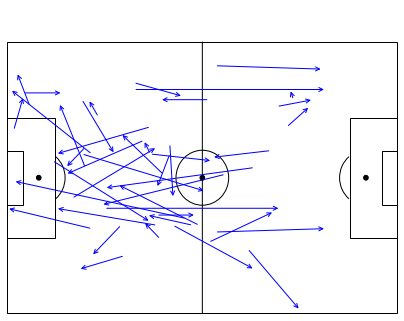

In [76]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-.1, 80)
plt.xlim(0, 120.1)
plt.axis('off')

for i in range(len(passes_Pjan)):
    # annotate draws an arrow from a current position to pass_end_location
    ax.annotate("",
                xy = (passes_Pjan.iloc[i]['positions'][1]['y'],
                          passes_Pjan.iloc[i]['positions'][1]['x']),
                xycoords = 'data',
                xytext = (passes_Pjan.iloc[i]['positions'][0]['y'],
                          passes_Pjan.iloc[i]['positions'][0]['x']),
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)

### Finding and plotting accurate passes

In [77]:
passes_Jorg['tags'] = list(map(lambda i: myFind(i, 1801), passes_Jorg['tags']))
passes_Pjan['tags'] = list(map(lambda i: myFind(i, 1801), passes_Pjan['tags']))

In [78]:
acc_Jorg = passes_Jorg[passes_Jorg.tags==1]
acc_Pjan = passes_Pjan[passes_Pjan.tags==1]

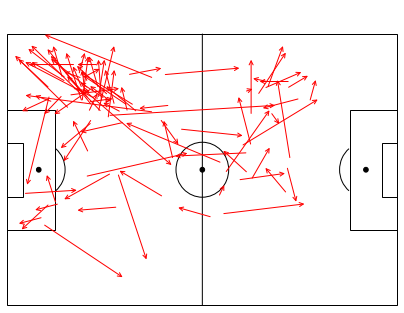

In [79]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-.1, 80)
plt.xlim(0, 120.1)
plt.axis('off')

for i in range(len(acc_Jorg)):
    # annotate draws an arrow from a current position to pass_end_location
    ax.annotate("",
                xy = (acc_Jorg.iloc[i]['positions'][1]['y'],
                      acc_Jorg.iloc[i]['positions'][1]['x']),
                xycoords = 'data',
                xytext = (acc_Jorg.iloc[i]['positions'][0]['y'],
                          acc_Jorg.iloc[i]['positions'][0]['x']),
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"),)

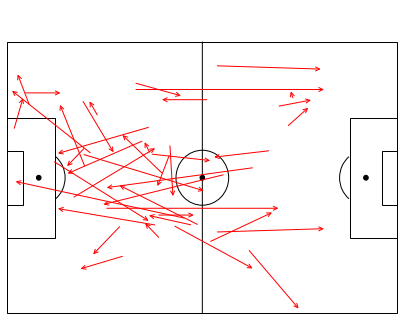

In [80]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-.1, 80)
plt.xlim(0, 120.1)
plt.axis('off')

for i in range(len(acc_Pjan)):
    # annotate draws an arrow from a current position to pass_end_location
    ax.annotate("",
                xy = (acc_Pjan.iloc[i]['positions'][1]['y'],
                      acc_Pjan.iloc[i]['positions'][1]['x']),
                xycoords = 'data',
                xytext = (acc_Pjan.iloc[i]['positions'][0]['y'],
                          acc_Pjan.iloc[i]['positions'][0]['x']),
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"),)

### Visualizing accurate and inaccurate passes together

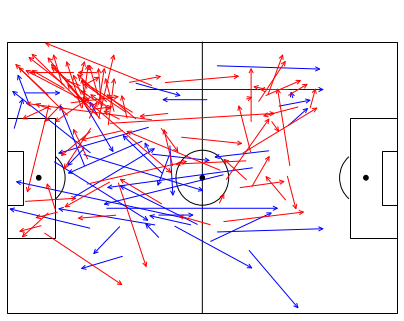

In [81]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-.1, 80)
plt.xlim(0, 120.1)
plt.axis('off')

for i in range(len(passes_Pjan)):
    # annotate draws an arrow from a current position to pass_end_location
    ax.annotate("",
                xy = (passes_Pjan.iloc[i]['positions'][1]['y'],
                          passes_Pjan.iloc[i]['positions'][1]['x']),
                xycoords = 'data',
                xytext = (passes_Pjan.iloc[i]['positions'][0]['y'],
                          passes_Pjan.iloc[i]['positions'][0]['x']),
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)
    
for i in range(len(acc_Jorg)):
    # annotate draws an arrow from a current position to pass_end_location
    ax.annotate("",
                xy = (acc_Jorg.iloc[i]['positions'][1]['y'],
                      acc_Jorg.iloc[i]['positions'][1]['x']),
                xycoords = 'data',
                xytext = (acc_Jorg.iloc[i]['positions'][0]['y'],
                          acc_Jorg.iloc[i]['positions'][0]['x']),
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"),)

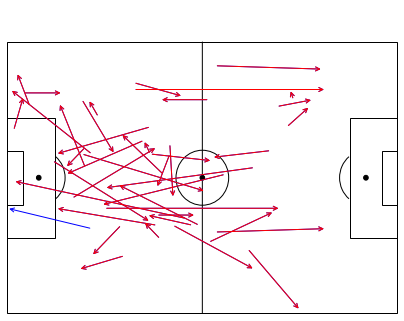

In [82]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-.1, 80)
plt.xlim(0, 120.1)
plt.axis('off')

for i in range(len(passes_Pjan)):
    # annotate draws an arrow from a current position to pass_end_location
    ax.annotate("",
                xy = (passes_Pjan.iloc[i]['positions'][1]['y'],
                          passes_Pjan.iloc[i]['positions'][1]['x']),
                xycoords = 'data',
                xytext = (passes_Pjan.iloc[i]['positions'][0]['y'],
                          passes_Pjan.iloc[i]['positions'][0]['x']),
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)

for i in range(len(acc_Pjan)):
    # annotate draws an arrow from a current position to pass_end_location
    ax.annotate("",
                xy = (acc_Pjan.iloc[i]['positions'][1]['y'],
                      acc_Pjan.iloc[i]['positions'][1]['x']),
                xycoords = 'data',
                xytext = (acc_Pjan.iloc[i]['positions'][0]['y'],
                          acc_Pjan.iloc[i]['positions'][0]['x']),
                textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"),)

It's clear that Pjanic had an accuracy of almost 100%, but we notice that he attempted way less passes, as we see below:

In [83]:
print('Number of passes of Jorginho = ', len(passes_Jorg))
print('Number of passes of Pjanic = ', len(passes_Pjan))

print('Number of accurate passes of Jorginho = ', len(acc_Jorg))
print('Number of accurate passes of Pjanic = ', len(acc_Pjan))

Number of passes of Jorginho =  114
Number of passes of Pjanic =  44
Number of accurate passes of Jorginho =  98
Number of accurate passes of Pjanic =  43
